In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
#from pyngrok import ngrok

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_DIR = "/content/drive/MyDrive/mashrooms-vision/"
IMG_DIR = DATASET_DIR + "dataset/dataset/"

app_path = DATASET_DIR + "app.py"
train_df = pd.read_csv(DATASET_DIR + "train.csv")
test_df = pd.read_csv(DATASET_DIR + "test.csv")

In [ ]:
train_df.head()

,Image,Mushroom
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
train_df.shape

(2365, 2)

In [5]:
print(train_df.isnull().sum())

Image       0
Mushroom    0
dtype: int64


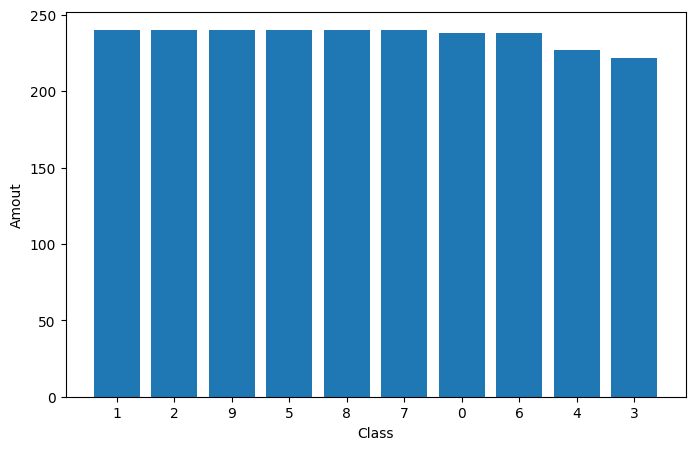

In [ ]:
class_counts = train_df['Mushroom'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(class_counts.index.astype(str), class_counts.values)

plt.xlabel("Class")
plt.ylabel("Amout")
plt.xticks(rotation=0)
plt.show()

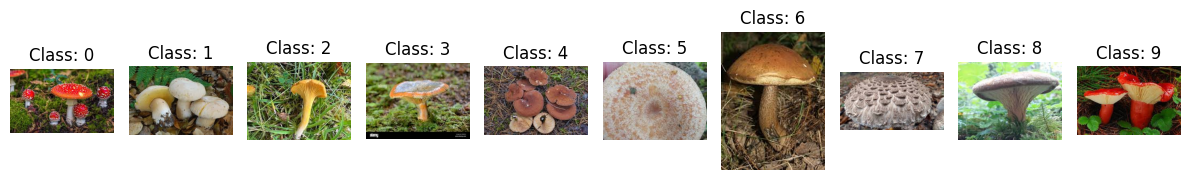

In [ ]:
classes = train_df['Mushroom'].unique()

plt.figure(figsize=(12, 6))

for i, cls in enumerate(classes):
    sample = train_df[train_df['Mushroom'] == cls].iloc[4]
    img_name = f"{sample['Image']:05d}.jpg"

    img_path = os.path.join(IMG_DIR, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img)
    plt.title(f"Class: {cls}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
bad = []
for file in os.listdir(IMG_DIR):
    img = cv2.imread(os.path.join(IMG_DIR, file))
    if img is None:
        bad.append(file)
bad

[]

##Data splitting for model training

In [23]:
train_unsampled, val = train_test_split(train_df, stratify=train_df['Mushroom'], test_size=0.2, random_state=42)
val, test = train_test_split(val, stratify=val['Mushroom'], test_size=0.25, random_state=42)

In [24]:
def pathify(df):
    df['Image'] = df['Image'].apply(lambda x: IMG_DIR + str(x).zfill(5) + ".jpg")
    return df

train_unsampled = pathify(train_unsampled)
val = pathify(val)
test = pathify(test)

In [ ]:
train_unsampled

,Image,Mushroom
370,/content/drive/MyDrive/mashrooms-vision/datase...,1
134,/content/drive/MyDrive/mashrooms-vision/datase...,0
904,/content/drive/MyDrive/mashrooms-vision/datase...,3
380,/content/drive/MyDrive/mashrooms-vision/datase...,1
2230,/content/drive/MyDrive/mashrooms-vision/datase...,9
...,...,...
1351,/content/drive/MyDrive/mashrooms-vision/datase...,5
1004,/content/drive/MyDrive/mashrooms-vision/datase...,4
223,/content/drive/MyDrive/mashrooms-vision/datase...,0
886,/content/drive/MyDrive/mashrooms-vision/datase...,3


In [ ]:
train_unsampled['Mushroom'].value_counts()

,count
Mushroom,
1,192
9,192
8,192
7,192
2,192
5,192
0,190
6,190
4,182


##Dataset preparation

In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = (224,224)

In [26]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    #image = image / 255.0 #only for b0
    return image, label

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((train_unsampled['Image'].values, train_unsampled['Mushroom'].values))
train_ds = train_ds.shuffle(len(train_unsampled)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val['Image'].values, val['Mushroom'].values))
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test['Image'].values, test['Mushroom'].values))
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##Dataset inspection and sanity check


In [ ]:
for x, y in train_ds.take(1):
    print("Batch images:", x.shape)
    print("Batch labels:", y.numpy())

Batch images: (32, 224, 224, 3)
Batch labels: [3 7 5 1 0 4 5 5 1 3 2 8 2 1 5 3 1 7 7 2 5 8 6 5 0 3 1 0 3 6 7 9]


In [ ]:
num_classes = train_unsampled['Mushroom'].nunique()
print("Number of classes:", num_classes)

print("Train classes:", train_unsampled['Mushroom'].unique())
print("Val classes:", val['Mushroom'].unique())
print("Test classes:", test['Mushroom'].unique())

print("Train distribution:\n", train_unsampled['Mushroom'].value_counts())
print("Val distribution:\n", val['Mushroom'].value_counts())
print("Test distribution:\n", test['Mushroom'].value_counts())

Number of classes: 10
Train classes: [1 0 3 9 7 2 5 8 6 4]
Val classes: [5 2 1 9 0 8 7 6 3 4]
Test classes: [6 2 8 5 9 4 7 3 0 1]
Train distribution:
 Mushroom
1    192
9    192
8    192
7    192
2    192
5    192
0    190
6    190
4    182
3    178
Name: count, dtype: int64
Val distribution:
 Mushroom
5    36
2    36
1    36
9    36
0    36
8    36
7    36
6    36
3    33
4    33
Name: count, dtype: int64
Test distribution:
 Mushroom
6    12
2    12
8    12
5    12
9    12
4    12
7    12
0    12
1    12
3    11
Name: count, dtype: int64


##Data Augmentation

In [8]:
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

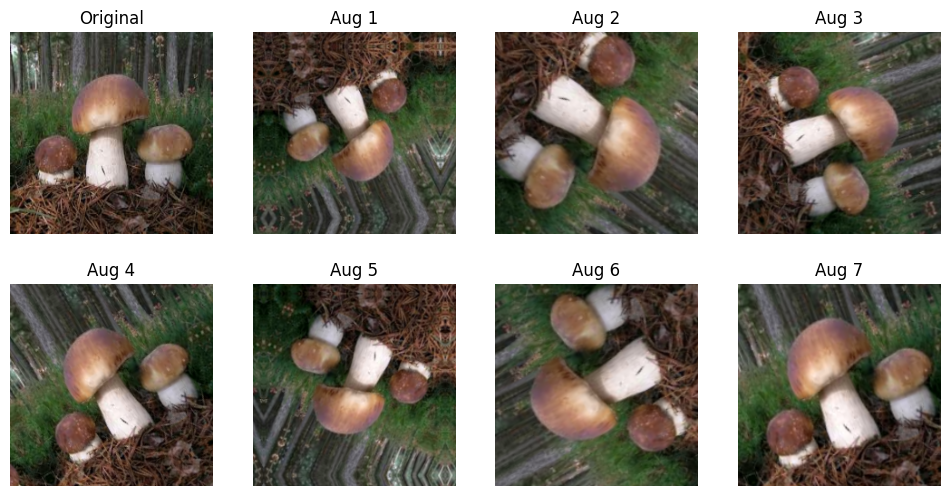

In [31]:
for image, label in train_ds.take(1):
    sample_image = image[0]
    break


augmented_images = [data_augment(tf.expand_dims(sample_image, 0)) for _ in range(7)]

plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

for i, img in enumerate(augmented_images):
    plt.subplot(2,4,i+2)
    plt.imshow(img[0].numpy().astype("uint8"))
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.show()

##Visualization Utilities

In [32]:
def plot_training_history(history, model_name="Model"):
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} – Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} – Loss")
    plt.legend()
    plt.grid(True)


In [14]:
def plot_confusion_matrix(
    model,
    dataset,
    class_labels,
    figsize=(8, 8),
    title="Confusion Matrix"
):

    y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)

    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_labels
    )

    plt.figure(figsize=figsize)
    disp.plot(
        cmap=plt.cm.Blues,
        xticks_rotation="vertical",
        ax=plt.gca()
    )
    plt.title(title)
    plt.show()


In [33]:
def evaluate_model_metrics_pretty(model, test_ds, class_names=None):
    y_pred_probs = model.predict(test_ds)
    if y_pred_probs.ndim > 1 and y_pred_probs.shape[1] > 1:
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = y_pred_probs.flatten().astype(int)

    if hasattr(test_ds, 'classes'):
        y_true = test_ds.classes
        if class_names is None:
            class_names = list(test_ds.class_indices.keys())
    else:
        y_true = np.concatenate([y for x, y in test_ds], axis=0)
        if y_true.ndim > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)
        if class_names is None:
            class_names = [str(i) for i in range(y_true.max() + 1)]

    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    df = pd.DataFrame(report_dict).transpose()

    df = df.round(2)

    print("=== Precision, Recall and F1-score")
    print(df)

    return df


##CNN models
####EfficientNetB0


In [ ]:
base_model_b0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)


base_model_b0.trainable = True
for layer in base_model_b0.layers[:40]:
    layer.trainable = False

model = tf.keras.Sequential([
    layers.Lambda(preprocess_input),
    data_augment,
    base_model_b0,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 286ms/step - accuracy: 0.1600 - loss: 2.9812 - val_accuracy: 0.4492 - val_loss: 1.8647 - learning_rate: 3.0000e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.4363 - loss: 1.7275 - val_accuracy: 0.6412 - val_loss: 1.2392 - learning_rate: 3.0000e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.5906 - loss: 1.2871 - val_accuracy: 0.7542 - val_loss: 0.8499 - learning_rate: 3.0000e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - accuracy: 0.6856 - loss: 0.9544 - val_accuracy: 0.7938 - val_loss: 0.6973 - learning_rate: 3.0000e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.7241 - loss: 0.8524 - val_accuracy: 0.8023 - val_loss: 0.6587 - learning_rate: 3.0000e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - accuracy: 0.7518 - loss: 0.7526 - val_accuracy: 0.8164 - val_loss: 0.6213 - learning_rate: 3.0000e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - acc

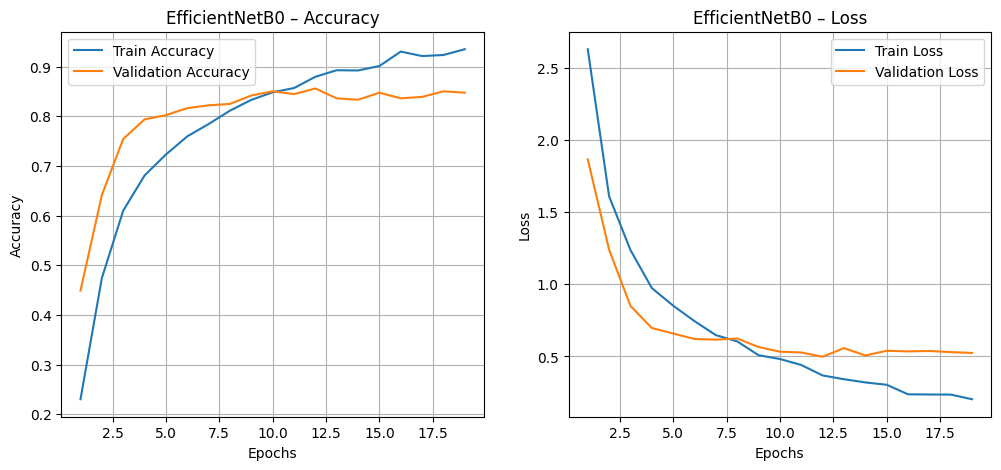

In [ ]:
plot_training_history(history, model_name="EfficientNetB0")

In [ ]:
model.save("/content/drive/MyDrive/mashrooms-vision/model-b0.keras")

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


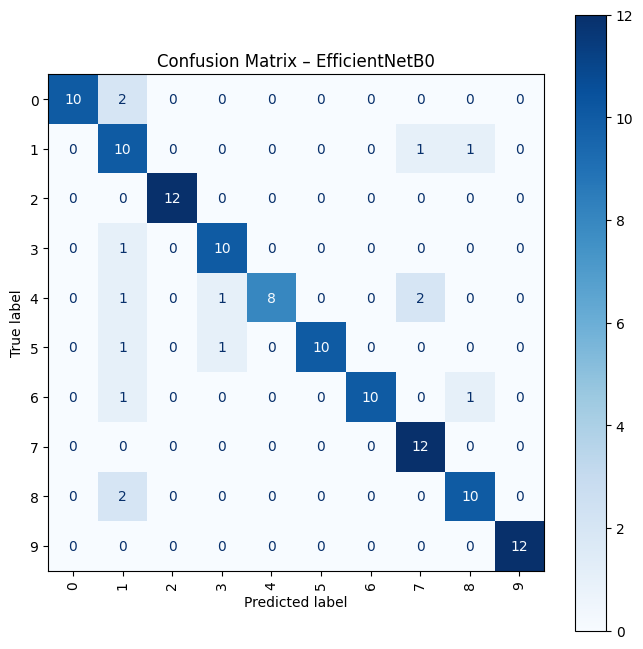

In [35]:
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/mashrooms-vision/model-b0.keras",
    custom_objects={"preprocess_input": preprocess_input}
)

labels = sorted(test['Mushroom'].unique())

plot_confusion_matrix(
    model=loaded_model,
    dataset=test_ds,
    class_labels=labels,
    title="Confusion Matrix – EfficientNetB0"
)

In [34]:
evaluate_model_metrics_pretty(loaded_model, test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
=== Precision, Recall and F1-score
              precision  recall  f1-score  support
0                  1.00    0.83      0.91    12.00
1                  0.56    0.83      0.67    12.00
2                  1.00    1.00      1.00    12.00
3                  0.83    0.91      0.87    11.00
4                  1.00    0.67      0.80    12.00
5                  1.00    0.83      0.91    12.00
6                  1.00    0.83      0.91    12.00
7                  0.80    1.00      0.89    12.00
8                  0.83    0.83      0.83    12.00
9                  1.00    1.00      1.00    12.00
accuracy           0.87    0.87      0.87     0.87
macro avg          0.90    0.87      0.88   119.00
weighted avg       0.90    0.87      0.88   119.00


,precision,recall,f1-score,support
0,1.00,0.83,0.91,12.00
1,0.56,0.83,0.67,12.00
2,1.00,1.00,1.00,12.00
3,0.83,0.91,0.87,11.00
4,1.00,0.67,0.80,12.00
5,1.00,0.83,0.91,12.00
6,1.00,0.83,0.91,12.00
7,0.80,1.00,0.89,12.00
8,0.83,0.83,0.83,12.00
9,1.00,1.00,1.00,12.00


####EfficientNetB3

In [33]:

base_model = EfficientNetB3(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)
base_model.trainable = False

model_b3 = tf.keras.Sequential([
    layers.Lambda(preprocess_input),
    data_augment,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

model_b3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1),
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_efficientnetb3.keras", save_best_only=True, verbose=1)
]

history = model_b3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
)

base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model_b3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model_b3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)

test_loss, test_acc = model_b3.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2365 - loss: 2.5608
Epoch 1: val_loss improved from inf to 1.72043, saving model to best_efficientnetb3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - accuracy: 0.2400 - loss: 2.5465 - val_accuracy: 0.3814 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 2/15
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5812 - loss: 1.3588
Epoch 2: val_loss improved from 1.72043 to 1.17326, saving model to best_efficientnetb3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5814 - loss: 1.3578 - val_accuracy: 0.6356 - val_loss: 1.1733 - learning_rate: 0.0010
Epoch 3/15
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6461 - loss: 1.1479
Epoch 3: val_loss improved from 1.17326 to 1.00936, saving model to best_efficientnetb3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.6460 - loss: 1.1484 - val_accuracy: 0.6780 - val_loss: 1.0094 - learning_

In [35]:
model_b3.save("/content/drive/MyDrive/mashrooms-vision/model-b3-100.keras")

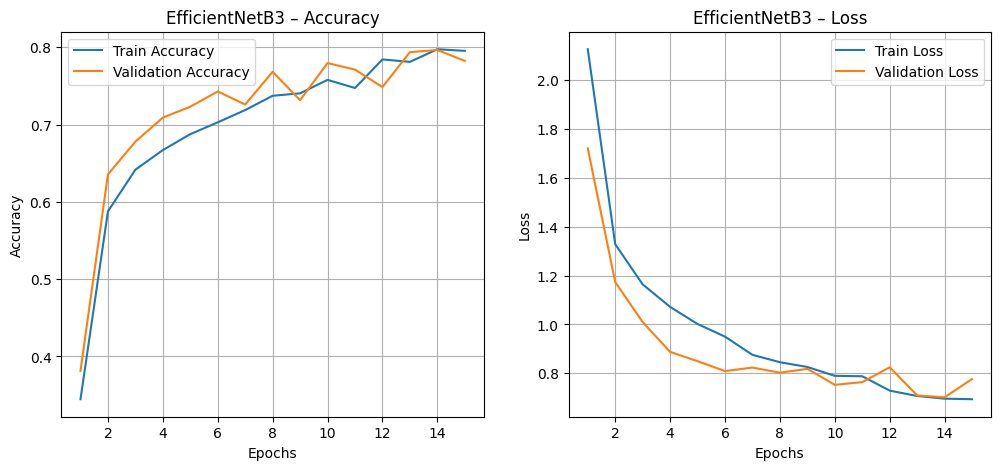

In [34]:
plot_training_history(history, model_name="EfficientNetB3")

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


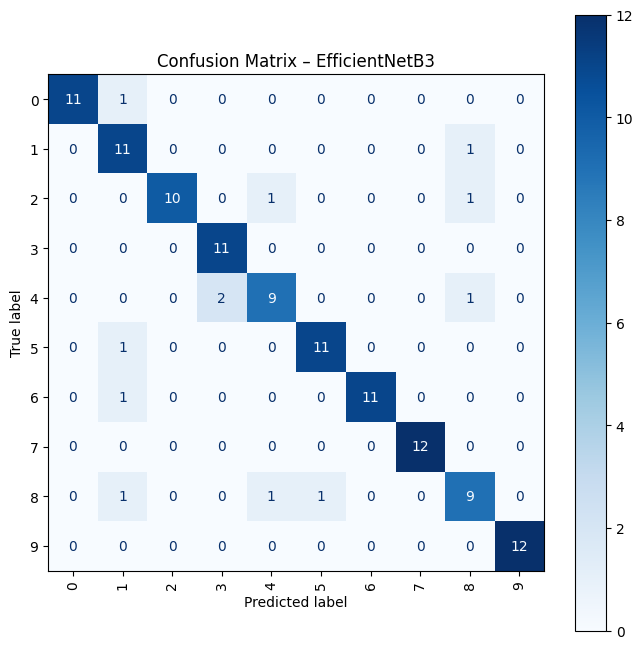

In [36]:
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/mashrooms-vision/model-b3-100.keras",
    custom_objects={"preprocess_input": preprocess_input}
)

labels = sorted(test['Mushroom'].unique())

plot_confusion_matrix(
    model=loaded_model,
    dataset=test_ds,
    class_labels=labels,
    title="Confusion Matrix – EfficientNetB3"
)

In [37]:
evaluate_model_metrics_pretty(loaded_model, test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
=== Precision, Recall and F1-score
              precision  recall  f1-score  support
0                  1.00    0.92      0.96     12.0
1                  0.73    0.92      0.81     12.0
2                  1.00    0.83      0.91     12.0
3                  0.85    1.00      0.92     11.0
4                  0.82    0.75      0.78     12.0
5                  0.92    0.92      0.92     12.0
6                  1.00    0.92      0.96     12.0
7                  1.00    1.00      1.00     12.0
8                  0.75    0.75      0.75     12.0
9                  1.00    1.00      1.00     12.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.91    0.90      0.90    119.0
weighted avg       0.91    0.90      0.90    119.0


,precision,recall,f1-score,support
0,1.00,0.92,0.96,12.0
1,0.73,0.92,0.81,12.0
2,1.00,0.83,0.91,12.0
3,0.85,1.00,0.92,11.0
4,0.82,0.75,0.78,12.0
5,0.92,0.92,0.92,12.0
6,1.00,0.92,0.96,12.0
7,1.00,1.00,1.00,12.0
8,0.75,0.75,0.75,12.0
9,1.00,1.00,1.00,12.0


####ResNet

In [43]:

base_model = ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

base_model.trainable = True
for layer in base_model.layers[:-120]:
    layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augment(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=l2(1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=l2(1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model_resnet = tf.keras.Model(
    inputs,
    outputs,
    name="ResNet50_Mushroom_Classifier"
)

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        "best_resnet50_mushrooms.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks,
    verbose=1
)


test_loss, test_acc = model_resnet.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.1612 - loss: 2.9593
Epoch 1: val_loss improved from inf to 1.61807, saving model to best_resnet50_mushrooms.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - accuracy: 0.1624 - loss: 2.9537 - val_accuracy: 0.4746 - val_loss: 1.6181 - learning_rate: 1.0000e-04
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4815 - loss: 1.6675
Epoch 2: val_loss improved from 1.61807 to 1.23251, saving model to best_resnet50_mushrooms.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.4819 - loss: 1.6658 - val_accuracy: 0.6469 - val_loss: 1.2325 - learning_rate: 1.0000e-04
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5835 - loss: 1.3761
Epoch 3: val_loss improved from 1.23251 to 0.91093, saving model to best_resnet50_mushrooms.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 467ms/step - accuracy: 0.5840 - loss: 1.3747 - val_accuracy: 0.7316 - val_loss

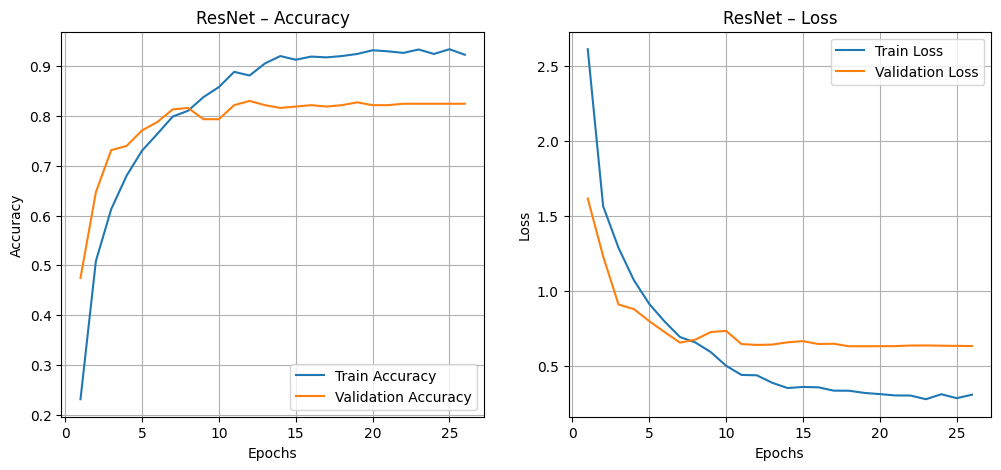

In [45]:
plot_training_history(history, model_name="ResNet")

In [44]:
model_resnet.save("/content/drive/MyDrive/mashrooms-vision/model-resnet.keras")

4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step


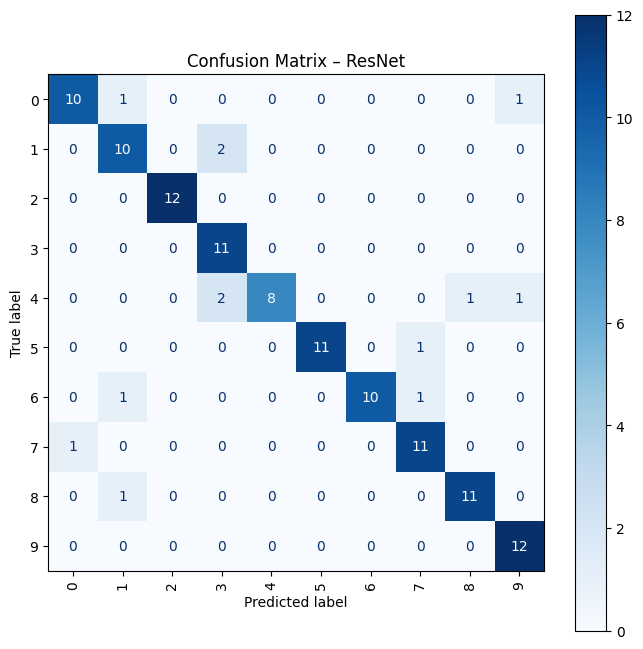

In [38]:
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/mashrooms-vision/model-resnet.keras",
    custom_objects={"preprocess_input": preprocess_input}
)

labels = sorted(test['Mushroom'].unique())

plot_confusion_matrix(
    model=loaded_model,
    dataset=test_ds,
    class_labels=labels,
    title="Confusion Matrix – ResNet"
)

In [39]:
evaluate_model_metrics_pretty(loaded_model, test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step
=== Precision, Recall and F1-score
              precision  recall  f1-score  support
0                  0.91    0.83      0.87    12.00
1                  0.77    0.83      0.80    12.00
2                  1.00    1.00      1.00    12.00
3                  0.73    1.00      0.85    11.00
4                  1.00    0.67      0.80    12.00
5                  1.00    0.92      0.96    12.00
6                  1.00    0.83      0.91    12.00
7                  0.85    0.92      0.88    12.00
8                  0.92    0.92      0.92    12.00
9                  0.86    1.00      0.92    12.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.90    0.89      0.89   119.00
weighted avg       0.90    0.89      0.89   119.00


,precision,recall,f1-score,support
0,0.91,0.83,0.87,12.00
1,0.77,0.83,0.80,12.00
2,1.00,1.00,1.00,12.00
3,0.73,1.00,0.85,11.00
4,1.00,0.67,0.80,12.00
5,1.00,0.92,0.96,12.00
6,1.00,0.83,0.91,12.00
7,0.85,0.92,0.88,12.00
8,0.92,0.92,0.92,12.00
9,0.86,1.00,0.92,12.00


In [6]:
model_names = ['EfficientNetB0', 'EfficientNetB3', 'ResNet50']

accuracies = [0.8739, 0.8991, 0.8908]
losses = [0.4412, 0.4792, 0.4868]

def plot_manual_model_comparison(
    model_names,
    accuracies,
    losses
):

    x = np.arange(len(model_names))
    width = 0.35

    plt.figure(figsize=(10, 5))

    plt.bar(x - width/2, accuracies, width, label='Accuracy')

    plt.bar(x + width/2, losses, width, label='Loss')

    plt.xticks(x, model_names)
    plt.ylabel('Value')
    plt.title('Model Comparison: Accuracy vs Loss')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

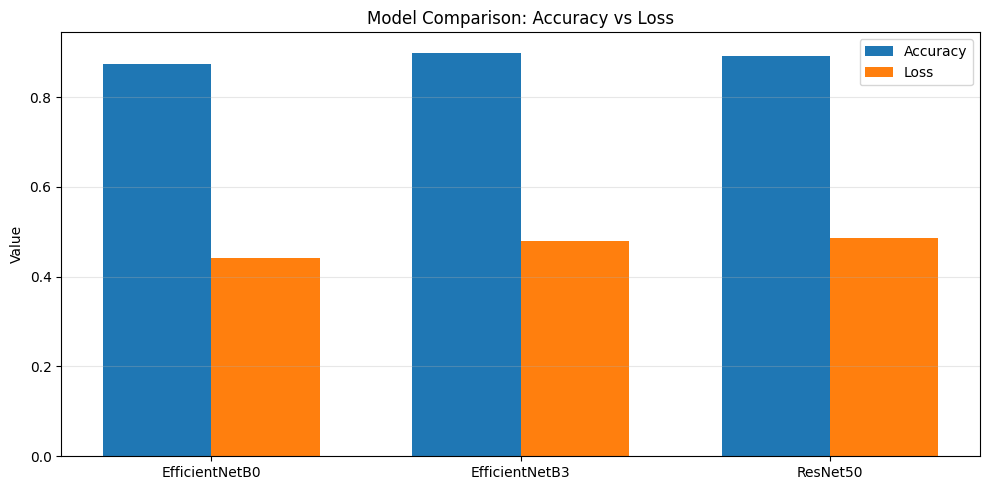

In [8]:
plot_manual_model_comparison(model_names, accuracies, losses)

##Streamlit App

In [ ]:
!killall ngrok

!pip install streamlit pyngrok
!streamlit run app_path &>/content/logs.txt &

ngrok.set_auth_token("2vAby2IpxxMqHSyp0ZtSWpTXbjX_5DGBJjggq1cyNHJfcrzLz")
print("\n\n\n", ngrok.connect(8501))




 NgrokTunnel: "https://46b6e74773f3.ngrok-free.app" -> "http://localhost:8501"
